In [1]:
import json
import random
import re
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

import sys
sys.path.insert(0, '..')
from utils.latex import add_colname, show_latex, TABLES
from utils.config import PATHS

In [2]:
pd.set_option("max_columns", None)

# Parse labels

This only needs to be done one time. Once the parsed df's are saved, you can skip to the 'Load data' section.

In [3]:
path = PATHS.getpath('resources_inception_config')
with open(path / 'tagset_legacy_stella.json', 'r') as f:
    tagset = json.load(f)['tags']

In [4]:
# Functions for parsing legacy annotations (pilot batch, "legacy_stella" tagset)
# The new versions of these functions (zonmw tagset) can be found in `parse_annotations.py`

def categorize_tags(tagset):
    """
    Categorize the tags in `tagset` into: domains, levels, disregard, target, background, other.

    Parameters
    ----------
    tagset: list
        list of dicts; each dict has a 'tag_name' key
    
    Returns
    -------
    dict
        dict of categories and the tags belonging to each of them
    """
    tag_names = [i['tag_name'].split(':')[0] for i in tagset]
    # define regexes
    rdomain = re.compile('\..*')
    rlevel = re.compile('[A-Z]{3} \d')
    rdisregard = re.compile('disregard_file')
    rtarget = re.compile('target')
    rbackground = re.compile('type_Background')
    # find categories
    domains = [tag for tag in tag_names if rdomain.match(tag)]
    levels = [tag for tag in tag_names if rlevel.match(tag)]
    disregard = [tag for tag in tag_names if rdisregard.match(tag)]
    target = [tag for tag in tag_names if rtarget.match(tag)]
    background = [tag for tag in tag_names if rbackground.match(tag)]
    other = [tag for tag in tag_names if tag not in domains + levels + disregard + target + background]
    return dict(
        domains=domains,
        levels=levels,
        disregard=disregard,
        target=target,
        background=background,
        other=other,
    )

def create_parse_index(conversions):
    domainlevels = zip(conversions.values(), [f"{i}_lvl" for i in conversions.values()])
    domainlevels = [i for domlev in domainlevels for i in domlev]
    return  pd.Index(domainlevels+['disregard', 'target', 'background', 'other'])

def parse_label(label, parse_index, cols_to_lbl, reg_others):
    s = pd.Series(index=parse_index, dtype=object)
    for idx in s.index:
        if idx in cols_to_lbl:
            s[idx] = cols_to_lbl[idx] in label
        elif '_lvl' in idx:
            regex = re.compile(f"{idx[:3]} (\d)")
            if regex.search(label):
                s[idx] = int(regex.search(label).group(1))
        else:
            s[idx] = reg_others.findall(label)
    return s

def parse_df(df, tagset):
    cat_tags = categorize_tags(tagset)
    conversions = {
        '.B152':     'STM',
        '.B455':     'INS',
        '.D450':     'FAC',
        '.D840-859': 'BER',
    }
    parse_index = create_parse_index(conversions)
    reg_others = re.compile('|'.join(cat_tags['other']))
    cols_to_lbl = {v:k for k,v in conversions.items()}
    cols_to_lbl['disregard'] = 'disregard\\_file'
    cols_to_lbl['target'] = 'target'
    cols_to_lbl['background'] = 'type\\_Background'

    parse_label_from_row = lambda row: parse_label(row.label, parse_index, cols_to_lbl, reg_others)
    select_labels = (df.label != '_') & df.label.notna()
    parsed = df.loc[select_labels].apply(parse_label_from_row, result_type='expand', axis=1)
    return df.join(parsed)

In [5]:
def deduplicate_notes(df):
    """
    Some notes are annotated more than once, by different annotators.
    Select one of the annotators randomly per note and keep her/his annotation only.
    """
    choices = df.groupby('NotitieID').annotator.unique().apply(random.choice).reset_index()
    selected = list(choices.values)
    return df.loc[df.set_index(['NotitieID', 'annotator']).index.isin(selected)]

def preprocessing(df, deduplicate=False):
    if deduplicate:
        df = deduplicate_notes(df)
    return df.assign(
        sen_id = lambda df: df.NotitieID.astype(str) + '_' + df.sen_tok.str.split('-').str[0],
        tok = lambda df: df.sen_tok.str.split('-').str[1].astype(int),
    )

# Load data

In [3]:
path = PATHS.getpath('data_expr_sept')
noncov = pd.read_pickle(path / 'pilot_noncov_parsed.pkl')
cov = pd.read_pickle(path / 'pilot_cov_parsed.pkl')

# Stats

In [4]:
df = noncov.assign(source='2017'
).append(
    cov.assign(source='cov_2020'), ignore_index=True
)
del noncov
del cov

## General overview

In [5]:
caption = "A-PROOF pilot: Number of annotated notes (incl. disregard)"
label = "pilot_annot_n_notes"

df.pivot_table(
    index='source',
    values='NotitieID',
    aggfunc='nunique',
    margins=True,
    margins_name='Total',
).rename(columns={'NotitieID': 'n_notes'}
).join(
        df.query("disregard == True").pivot_table(
        index='source',
        values='NotitieID',
        aggfunc='nunique',
        margins=True,
        margins_name='Total',
    ).rename(columns={'NotitieID': 'n_disregard'})
).assign(
    n_annotated=lambda df: df.n_notes - df.n_disregard,
    prc_disregard=lambda df: (df.n_disregard / df.n_notes).mul(100).round(0),
).pipe(show_latex, caption=caption, label=label)

,n_notes,n_disregard,n_annotated,prc_disregard
source,,,,
2017,"3,377",329,"3,048",10.0
cov_2020,"1,687",104,"1,583",6.0
Total,"5,064",433,"4,631",9.0


## Domains & Levels

Analysis according to the following guidelines:

- **domains**: group by sentence, count domain once in sentence if it occurs at least once
- **levels**: group by sentence, same level per sentence is counted once, different levels are counted separately

In [6]:
domains = ['BER', 'FAC', 'INS', 'STM']
rows_with_domain = df.loc[df[domains].notna().any(axis=1)]
domain_totals_per_sen_id = rows_with_domain.groupby(['source', 'sen_id'])[domains].any()

In [7]:
caption = "A-PROOF pilot: Number of sentences with domain labels (excl. disregard)"
label = "pilot_annot_sents_w_domain_labels"

n_sent = df.groupby('source').sen_id.nunique()

n_sent_with_label = df.assign(
    has_domain = lambda df: df[domains].any(axis=1),
).query("has_domain == True").groupby('source').sen_id.nunique()

table = pd.concat([
    n_sent.rename('n_all_sents'),
    n_sent_with_label.rename('n_sents_with_labels'),
], axis=1)
table.loc['total'] = table.sum()
table.assign(prc_sents_with_labels=lambda df: (df.n_sents_with_labels / df.n_all_sents).mul(100).round(1)
).pipe(show_latex, caption=caption, label=label)

,n_all_sents,n_sents_with_labels,prc_sents_with_labels
source,,,
2017,"218,863","3,419",1.6
cov_2020,"94,431","1,016",1.1
total,"313,294","4,435",1.4


In [9]:
caption = "A-PROOF pilot: Distribution of domains"
label = "pilot_annot_domains"

n_labels = domain_totals_per_sen_id.pivot_table(
    index='source',
    values=domains,
    aggfunc='sum',
    margins=True,
    margins_name='total',
).assign(total=lambda df: df.sum(axis=1))

p_labels = (n_labels.div(n_labels.iloc[:, -1], axis=0) * 100).round()

piv = n_labels.pipe(add_colname, 'n').join(
    p_labels.pipe(add_colname, '%')
).astype('Int64'
).sort_index(axis=1, level=[0,1], ascending=[True, False])

piv.pipe(show_latex, caption=caption, label=label)

BER       FAC      INS        STM      total     
            n  %      n   %    n   %      n   %      n    %
source                                                     
2017      268  8  1,112  31  646  18  1,532  43  3,558  100
cov_2020    5  0    319  31  256  25    460  44  1,040  100
total     273  6  1,431  31  902  20  1,992  43  4,598  100

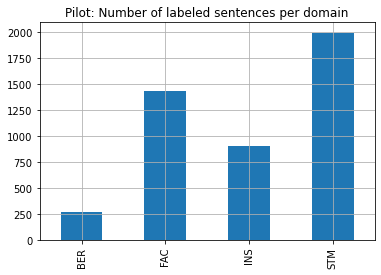

In [11]:
# total number of labels

fig, ax = plt.subplots(figsize=(6, 4))
piv.loc[['total']].xs('n', axis=1, level=1).iloc[:,:-1].T.plot.bar(
    ax=ax,
    legend=False, 
    grid=True, 
    title='Pilot: Number of labeled sentences per domain',
)
fig.savefig('figures/pilot_total_n_domains.png')

In [12]:
caption = "A-PROOF pilot: Distribution of levels per domain"
label = "pilot_annot_levels"

stats = []
for lvl in [f"{i}_lvl" for i in domains]:
    notna = df.loc[df[lvl].notna()]
    stat = notna.groupby(['source', 'sen_id'])[lvl].apply(lambda s: {i for i in s if i==i})
    stat = stat.explode().groupby(level=0).value_counts()
    stats.append(stat)
table = pd.concat(stats, axis=1)
table.index = pd.MultiIndex.from_tuples([(i,int(j)) for i,j in table.index])
sums = table.groupby(level=0).sum()
sums.index = pd.MultiIndex.from_tuples([(i, 'Total') for i in sums.index])
table = pd.concat([table, sums]).sort_index(level=0)

prcs = table.div(sums.xs('Total', level=1), axis=1, level=0).mul(100).round()
pd.concat(
    [table, prcs], keys=['n', '%'], axis=1
).rename_axis(['source', 'level']
).swaplevel(axis=1
).sort_index(axis=1, level=[0,1], ascending=[True,False]
).astype('Int64'
).pipe(show_latex, caption=caption, label=label)

BER_lvl       FAC_lvl      INS_lvl      STM_lvl      
                     n     %       n    %       n    %       n     %
source   level                                                      
2017     0          64    32      77    9      26    4     270    17
         1           6     3      27    3      95   16     876    57
         2          30    15      53    6     108   19     158    10
         3          28    14     106   12     128   22     179    12
         4          69    35     532   59      95   16      63     4
         5        <NA>  <NA>     108   12     126   22    <NA>  <NA>
         Total     197   100     903  100     578  100   1,546   100
cov_2020 0           1    33     156   52      71   29      93    20
         1        <NA>  <NA>      25    8     111   45     215    45
         2        <NA>  <NA>      22    7      40   16      75    16
         3        <NA>  <NA>      37   12      21    8      62    13
         4           2    67      61   20       4    2      29     6
         5        <NA>  <NA>       1    0       2    1    <NA>  <NA>
         Total       3   100     302  100     249  100     474   100

In [22]:
prefix = 'pilot_annot'
for idx, table in enumerate(TABLES):
    with open(f'./tables/{prefix}_{idx}.tex', 'w', encoding='utf8') as f:
        f.write(table)